In [17]:
import sys
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np


##import 
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")),"Code","Travis"))
import stats
import utils
import plotting
import responses_analysis
import importlib
import dfof
import numpy as np
from response2p.bandwidth import bandwidth as bw
from response2p.bestFrequency import bestFrequency as bf
from response2p.characteristicFrequency import characteristicFrequency as cf
from response2p.respondsToFreqs import respondsToFreqs as rFreqs
from response2p.responseStats import getResponses, responseStats
import config

color_dict = config.color_dict
order = config.order
save_path = config.save_path
data_path = config.data_path
if not save_path.exists():
    save_path.mkdir()

In [18]:
sig_responding_neurons = []
total_neurons = []
meancorrs = []
noisecorrs = []
force = False

test = utils.findUnanalyzedStacks(data_path, pattern="**/2P/L23/[0-9]*", foldername="all")
twop_mice = responses_analysis.get2Pmice(data_path, test)
responseProperties = pd.DataFrame()

for index, row in twop_mice.iterrows():
    print(row['Mouse'])
    analysis_dir = row['2P_path'] / "response_analysis"
    if not analysis_dir.exists():
        (row['2P_path'] / "response_analysis").mkdir()

    if (analysis_dir / "unmixed.npy").exists():
        unmixed = np.load(analysis_dir / "unmixed.npy")
    else:
        temp = dfof.processFluor(dir = row['2P_path'])
        temp.loadTraces()
        temp.calc_dfof(window=500, step = 50, percentile=10, cutoff = 20)
        temp.unmix(numBaseline=15, framesAfter=60)
        np.save(analysis_dir / "unmixed.npy", temp.unmixed)

    responsive_file = analysis_dir / "isResponsive.csv"
    if responsive_file.exists() and not force:
        isResponsive = pd.read_csv(responsive_file)
    else:
        isResponsive = responses_analysis.isResponsive(unmixed, alpha = 0.01)
        isResponsive.to_csv(responsive_file, index=False)


    ####now which responses are sound responsive?
    response_stats_file = analysis_dir / "responseStats.csv"
    if response_stats_file.exists() and not force:
        df_stats = pd.read_csv(response_stats_file)
    else:
        df = getResponses(unmixed)
        df_stats = responseStats(df, isResponsive)
        df_stats.to_csv(response_stats_file, index=False)

    bfreqs = bf(df_stats)
    cfreqs = cf(df_stats)
    bws = bw(df_stats, attenLevel=1, mustBeContinuous=True)
    freqResponders = rFreqs(df_stats, rejectAtten=[0,2,3])

    temp = bfreqs.merge(cfreqs, on='neuron')
    temp = temp.merge(freqResponders, on='neuron')
    temp = temp.merge(bws, on = 'neuron')
    temp['Mouse'] = row['Mouse']
    responseProperties = pd.concat((responseProperties, temp))
    

**/2P/L23/[0-9]* all
m602
m603
m609
m670
m674
m675
m659
m722
m664
m666
m900
m984
m985
m1315
m1321
m1318
m1323
m1493
m1937
m2065
m1983


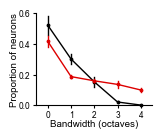

In [19]:
##Bandwidth
## only two genos
response_df = pd.merge(twop_mice, responseProperties, on = 'Mouse')
two_genos = response_df[response_df['Genotype']!= '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)']
grouped = two_genos.groupby(['Genotype','Mouse'])['bw'].value_counts(normalize=True, bins=np.arange(-0.5,5,1))

g2 = grouped.reset_index()
g2['sortkey']=g2.bw.map(lambda x : x.left)
g2['bw_int']= pd.cut(g2['sortkey'], bins=np.arange(-0.6,5,1), labels = [0,1,2,3,4],ordered=True)

fig, ax = plt.subplots(figsize=(1.5,1.2))
sns.pointplot(data=g2, x='bw_int', y = 'proportion', hue='Genotype', hue_order=order, linewidth = 1, errorbar = 'se', marker='o', markersize=2, palette = color_dict, clip_on = False)
#sns.stripplot(data=g2, x='bw', y = 'proportion', hue='Genotype', hue_order=order, dodge=True, size = 0.2, linewidth = 1, marker='.', palette = color_dict)
#sns.barplot(data=g2, x='bestFreq', y = 'proportion', hue='Genotype', errorbar = 'se', width =0.5, palette = color_dict)
ax.get_legend().remove()
plotting.figQuality(plt.gcf(), plt.gca())
#plt.title("Bandwidth", fontsize=8, fontweight='bold')

plt.ylabel("Proportion of neurons", fontsize=7,labelpad = 0)
plt.xlabel("Bandwidth (octaves)", fontsize = 7,labelpad=0)

plt.yticks(np.arange(0,0.8, 0.2))
plt.ylim([0,0.6])
plt.savefig(save_path / "Fig3_F_Bandwidth.svg")

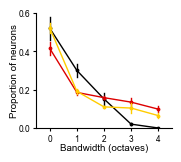

In [20]:
## all three genos
response_df = pd.merge(twop_mice, responseProperties, on = 'Mouse')
grouped = response_df.groupby(['Genotype','Mouse'])['bw'].value_counts(normalize=True, bins=np.arange(-0.5,5,1))

g2 = grouped.reset_index()
g2['sortkey']=g2.bw.map(lambda x : x.left)
g2['bw_int']= pd.cut(g2['sortkey'], bins=np.arange(-0.6,5,1), labels = [0,1,2,3,4],ordered=True)

fig, ax = plt.subplots(figsize=(1.75,1.5))
sns.pointplot(data=g2, x='bw_int', y = 'proportion', hue='Genotype', hue_order=order, linewidth = 1, errorbar = 'se', marker='o', markersize=2, palette = color_dict)
#sns.stripplot(data=g2, x='bw', y = 'proportion', hue='Genotype', hue_order=order, dodge=0.2, size = 0.2, linewidth = 1, marker='.', palette = color_dict)
#sns.barplot(data=g2, x='bestFreq', y = 'proportion', hue='Genotype', errorbar = 'se', width =0.5, palette = color_dict)
ax.get_legend().remove()
plotting.figQuality(plt.gcf(), plt.gca())
#plt.ylim([0,0.4])

plt.ylabel("Proportion of neurons", fontsize=7,labelpad = 0)
plt.xlabel("Bandwidth (octaves)", fontsize = 7,labelpad=0)

plt.yticks(np.arange(0,0.600001, 0.2))
plt.ylim([0,0.6])
plt.savefig(save_path / "SF2_B_Bandwidth_3genos.svg")


In [21]:
model = ols('proportion ~ C(Genotype) + C(bw_int) + C(Genotype):C(bw_int)', data=g2).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Genotype),3.283210e-29,2.0,3.122714e-27,1.000000e+00
C(bw_int),2.458780e+00,4.0,1.169293e+02,8.718180e-35
C(Genotype):C(bw_int),2.194171e-01,8.0,5.217278e+00,2.272695e-05
Residual,4.731283e-01,90.0,NaN,NaN


In [22]:
importlib.reload(stats)
bw_stats = stats.ttests(g2,'bw','proportion')
bw_stats.sort_values(by=['geno1','geno2','bw'])

,geno1,geno2,bw,mean1,std1,mean2,std2,pval,reject_hs,pval_corrected
0,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),"(-0.501, 0.5]",0.522420,0.058807,0.415855,0.094308,0.046092,False,0.086422
1,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),"(0.5, 1.5]",0.192711,0.026037,0.187239,0.032646,0.758209,False,0.874856
2,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),"(1.5, 2.5]",0.112088,0.015056,0.159942,0.025192,0.002910,True,0.008730
3,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),"(2.5, 3.5]",0.105999,0.054422,0.136668,0.060602,0.376963,False,0.471204
4,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),"(3.5, 4.5]",0.066783,0.025290,0.100296,0.042098,0.139279,False,0.226976
5,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),"(-0.501, 0.5]",0.522420,0.058807,0.520792,0.171305,0.984230,False,0.984230
6,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),"(0.5, 1.5]",0.192711,0.026037,0.301350,0.100002,0.038907,False,0.083373
7,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),"(1.5, 2.5]",0.112088,0.015056,0.153207,0.085861,0.318913,False,0.434882
8,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),"(2.5, 3.5]",0.105999,0.054422,0.022314,0.016514,0.001613,True,0.006051
9,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),"(3.5, 4.5]",0.066783,0.025290,0.002336,0.002976,0.000015,True,0.000112


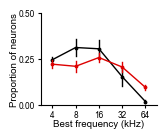

In [23]:
### 2 genotypes
response_df = pd.merge(twop_mice, responseProperties, on = 'Mouse')
two_genos = response_df[response_df['Genotype']!= '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)']
grouped = two_genos.groupby(['Genotype','Mouse'])['bestFreq'].value_counts(normalize=True)
g2 = grouped.reset_index()

g2['bestFreqkhz'] = g2['bestFreq'].replace({0:4,1:8,2:16,3:32,4:64})
fig, ax = plt.subplots(figsize=(1.5,1.2))
sns.pointplot(data=g2, x='bestFreqkhz', y = 'proportion', hue='Genotype', hue_order=order, linewidth = 1, errorbar = 'se', marker='o', markersize=2, palette = color_dict, clip_on = False)
ax.get_legend().remove()
plotting.figQuality(plt.gcf(), plt.gca())
#plt.title("Bandwidth", fontsize=8, fontweight='bold')

plt.ylabel("Proportion of neurons", fontsize=7,labelpad = 0)
plt.xlabel("Best frequency (kHz)", fontsize = 7,labelpad= 0)
plt.yticks()
plt.yticks(np.arange(0,0.6,0.25))
plt.ylim([0,0.5])
plt.savefig(save_path / "Fig3_G_bestFrequency.svg")

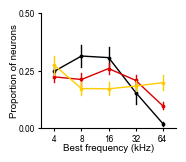

In [24]:
### 3 genotypes
# response_df = pd.merge(twop_mice, responseProperties, on = 'Mouse')
order = ['Thy1-GC6s; Cdh23 (ahl/ahl)','Thy1-GC6s; Cdh23 (Ahl/ahl)', '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)']
grouped = response_df.groupby(['Genotype','Mouse'])['bestFreq'].value_counts(normalize=True)
g2 = grouped.reset_index()
g2['bestFreqkhz'] = g2['bestFreq'].replace({0:4,1:8,2:16,3:32,4:64})
fig, ax = plt.subplots(figsize=(1.75,1.5))
sns.pointplot(data=g2, x='bestFreqkhz', y = 'proportion', hue='Genotype', hue_order=order, linewidth = 1, errorbar = 'se', marker='o', markersize=2, palette = color_dict)
#sns.barplot(data=g2, x='bestFreq', y = 'proportion', hue='Genotype', errorbar = 'se', width =0.5, palette = color_dict)
ax.get_legend().remove()
plotting.figQuality(plt.gcf(), plt.gca())
plt.ylim([0,0.4])
plt.ylabel("Proportion of neurons", fontsize=7,labelpad = 0)
plt.xlabel("Best frequency (kHz)", fontsize = 7,labelpad= 0)
plt.yticks()
plt.yticks(np.arange(0,0.6,0.25))
plt.ylim([0,0.5])

plt.savefig(save_path / "SF2_B_bestFrequency_3genos.svg")


In [25]:
model = ols('proportion ~ C(Genotype) + C(bestFreq) +C(Genotype):C(bestFreq)', data=g2).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Genotype),0.005394,2.0,0.390501,6.779114e-01
C(bestFreq),0.326385,4.0,11.815027,1.076896e-07
C(Genotype):C(bestFreq),0.226067,8.0,4.091781,3.621138e-04
Residual,0.593928,86.0,NaN,NaN


In [26]:
bf_stats = stats.ttests(g2,'bestFreq','proportion')
bf_stats.sort_values(by=["geno1","geno2","bestFreq"])

,geno1,geno2,bestFreq,mean1,std1,mean2,std2,pval,reject_hs,pval_corrected
0,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),0,0.273669,0.091902,0.223192,0.059839,0.251434,False,0.471439
4,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),1,0.172881,0.063273,0.211883,0.083556,0.392109,False,0.490137
2,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),2,0.171522,0.062473,0.259288,0.071129,0.045062,False,0.146990
1,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),3,0.183687,0.050522,0.207906,0.071291,0.523764,False,0.561176
3,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),4,0.198241,0.070086,0.097730,0.042704,0.007764,True,0.038821
5,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),0,0.273669,0.091902,0.247610,0.047238,0.509299,False,0.561176
9,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),1,0.172881,0.063273,0.313524,0.131593,0.049326,False,0.146990
7,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),2,0.171522,0.062473,0.306571,0.132732,0.058796,False,0.146990
6,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),3,0.183687,0.050522,0.155400,0.125498,0.649624,False,0.649624
8,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),4,0.198241,0.070086,0.020993,0.020275,0.000213,True,0.003188


                      Genotype  Mouse  charFreq  proportion  charFreqkhz
0   Thy1-GC6s; Cdh23 (Ahl/ahl)  m1315         1    0.286713            8
1   Thy1-GC6s; Cdh23 (Ahl/ahl)  m1315         2    0.220280           16
2   Thy1-GC6s; Cdh23 (Ahl/ahl)  m1315         4    0.174825           64
3   Thy1-GC6s; Cdh23 (Ahl/ahl)  m1315         0    0.160839            4
4   Thy1-GC6s; Cdh23 (Ahl/ahl)  m1315         3    0.157343           32
..                         ...    ...       ...         ...          ...
75  Thy1-GC6s; Cdh23 (ahl/ahl)   m674         1    0.680108            8
76  Thy1-GC6s; Cdh23 (ahl/ahl)   m674         4    0.120968           64
77  Thy1-GC6s; Cdh23 (ahl/ahl)   m674         3    0.069892           32
78  Thy1-GC6s; Cdh23 (ahl/ahl)   m674         0    0.067204            4
79  Thy1-GC6s; Cdh23 (ahl/ahl)   m674         2    0.061828           16

[80 rows x 5 columns]


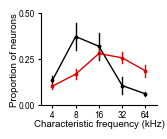

In [27]:
response_df = pd.merge(twop_mice, responseProperties, on = 'Mouse')
two_genos = response_df[response_df['Genotype']!= '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)']
grouped = two_genos.groupby(['Genotype','Mouse'])['charFreq'].value_counts(normalize=True)
g2 = grouped.reset_index()
g2['charFreqkhz'] = g2['charFreq'].replace({0:4,1:8,2:16,3:32,4:64})
print(g2)
fig, ax = plt.subplots(figsize=(1.5,1.2))
sns.pointplot(data=g2, x='charFreqkhz', y = 'proportion', hue='Genotype', hue_order=order, linewidth = 1, errorbar = 'se', marker='o', markersize=2, palette = color_dict, clip_on = False)
ax.get_legend().remove()
plotting.figQuality(plt.gcf(), plt.gca())
#plt.title("Bandwidth", fontsize=8, fontweight='bold')

plt.ylabel("Proportion of neurons", fontsize=7,labelpad = 0)
plt.xlabel("Characteristic frequency (kHz)", fontsize = 7,labelpad= 0)
plt.yticks()
plt.yticks(np.arange(0,0.6,0.25))
plt.ylim([0,0.5])
plt.savefig(save_path / "Fig3_H_charFrequency.svg")

                            Genotype Mouse  charFreq  proportion  charFreqkhz
0    (F1) Thy1-GC6s; Cdh23 (Ahl/ahl)  m659         3    0.330097           32
1    (F1) Thy1-GC6s; Cdh23 (Ahl/ahl)  m659         0    0.213592            4
2    (F1) Thy1-GC6s; Cdh23 (Ahl/ahl)  m659         2    0.184466           16
3    (F1) Thy1-GC6s; Cdh23 (Ahl/ahl)  m659         4    0.155340           64
4    (F1) Thy1-GC6s; Cdh23 (Ahl/ahl)  m659         1    0.116505            8
..                               ...   ...       ...         ...          ...
100       Thy1-GC6s; Cdh23 (ahl/ahl)  m674         1    0.680108            8
101       Thy1-GC6s; Cdh23 (ahl/ahl)  m674         4    0.120968           64
102       Thy1-GC6s; Cdh23 (ahl/ahl)  m674         3    0.069892           32
103       Thy1-GC6s; Cdh23 (ahl/ahl)  m674         0    0.067204            4
104       Thy1-GC6s; Cdh23 (ahl/ahl)  m674         2    0.061828           16

[105 rows x 5 columns]


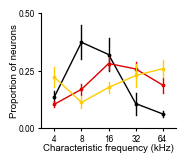

In [28]:
### 3 genos
response_df = pd.merge(twop_mice, responseProperties, on = 'Mouse')
grouped = response_df.groupby(['Genotype','Mouse'])['charFreq'].value_counts(normalize=True)
g2 = grouped.reset_index()
g2['charFreqkhz'] = g2['charFreq'].replace({0:4,1:8,2:16,3:32,4:64})
print(g2)
fig, ax = plt.subplots(figsize=(1.75,1.5))
sns.pointplot(data=g2, x='charFreqkhz', y = 'proportion', hue='Genotype', hue_order=order, linewidth = 1, errorbar = 'se', marker='o', markersize=2, palette = color_dict, clip_on = False)
ax.get_legend().remove()
plotting.figQuality(plt.gcf(), plt.gca())
#plt.title("Bandwidth", fontsize=8, fontweight='bold')

plt.ylabel("Proportion of neurons", fontsize=7,labelpad = 0)
plt.xlabel("Characteristic frequency (kHz)", fontsize = 7,labelpad= 0)
plt.yticks()
plt.yticks(np.arange(0,0.6,0.25))
plt.ylim([0,0.5])
plt.savefig(save_path / "SF2_B_charFrequency_3genos.svg")

In [29]:
model = ols('proportion ~ C(Genotype) + C(charFreq) +C(Genotype):C(charFreq)', data=g2).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Genotype),5.327739e-30,2.0,2.176173e-28,1.000000
C(charFreq),2.339687e-01,4.0,4.778352e+00,0.001531
C(Genotype):C(charFreq),5.971096e-01,8.0,6.097398e+00,0.000003
Residual,1.101697e+00,90.0,NaN,NaN


In [30]:
cf_stats = stats.ttests(g2,'charFreqkhz','proportion')
cf_stats.sort_values(by=['geno1','geno2','charFreqkhz'])

,geno1,geno2,charFreqkhz,mean1,std1,mean2,std2,pval,reject_hs,pval_corrected
1,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),4,0.221869,0.096038,0.104736,0.037572,0.009228,True,0.046140
4,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),8,0.112646,0.058768,0.169359,0.071152,0.165186,False,0.223981
2,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),16,0.177394,0.056808,0.281097,0.075107,0.023170,True,0.049650
0,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),32,0.229316,0.111331,0.257623,0.083341,0.609647,False,0.624751
3,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (Ahl/ahl),64,0.258775,0.083313,0.187185,0.089848,0.179185,False,0.223981
6,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),4,0.221869,0.096038,0.136817,0.067622,0.086098,False,0.161433
9,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),8,0.112646,0.058768,0.372964,0.209095,0.021492,True,0.049650
7,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),16,0.177394,0.056808,0.319998,0.206785,0.165694,False,0.223981
5,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),32,0.229316,0.111331,0.107673,0.134418,0.119796,False,0.199660
8,(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),64,0.258775,0.083313,0.062548,0.031515,0.000074,True,0.001117
